In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/ext-daniel-packer/documents/noteboooks/neural-geometry


In [13]:
from src.generate_embeddings import train_model, get_embedding
from src.MNIST import embed, load_data, batched_predict_on_embedded
import ott
from matplotlib import pyplot as plt, colormaps

from jax import nn, numpy as jnp, vmap, random
import numpy as np

In [5]:
rngs = random.split(random.PRNGKey(0), 2)

In [6]:
layer_sizes_1 = [200, 10, 200]
layer_sizes_2 = [200, 10, 200]
params_1 = train_model(layer_sizes_1, key=rngs[0], verbose = False, num_epochs=3)
params_2 = train_model(layer_sizes_2, key=rngs[1], verbose = False, num_epochs=3)

In [7]:
train_embedding_1, test_embedding_1, train_labels_1, test_labels_1 = get_embedding(1_000, params_1, 2)
train_embedding_2, test_embedding_2, train_labels_2, test_labels_2 = get_embedding(1_000, params_2, 2)

In [ ]:
geom_1 = ott.geometry.pointcloud.PointCloud(test_embedding_1, scale_cost="mean")
geom_2 = ott.geometry.pointcloud.PointCloud(test_embedding_2, scale_cost="mean")
prob = ott.problems.quadratic.quadratic_problem.QuadraticProblem(geom_1, geom_2, scale_cost=True)
# solver = ott.solvers.quadratic.lower_bound.LowerBoundSolver(epsilon=0.0001)
solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=0.005)
soln = solver(prob, max_iterations=10_000)
print(f"{soln.converged=}")

In [ ]:
def cross_predict(embedded_1):
    probs = nn.softmax(train_embedding_1 @ embedded_1 / jnp.linalg.norm(train_embedding_1))
    cross_probs = soln.matrix.T @ probs
    cross_probs /= cross_probs.sum()
    return (train_labels * cross_probs[:, None]).sum(0)

batched_cross_predict = vmap(cross_predict)

In [ ]:
# jnp.linalg.norm(train_embedding_1 @ train_embedding_1[0])


In [ ]:
plt.imshow(soln.matrix, norm="log")

In [120]:
test_pred = batched_cross_predict(test_embedding_1)
print(f"test accuracy: {(test_pred.argmax(1) == test_labels.argmax(1)).mean()}")
# print(f"test loss: {-y * np.log(out) - (1 - y)*np.log(1 - out)})

test accuracy: 0.22700001299381256


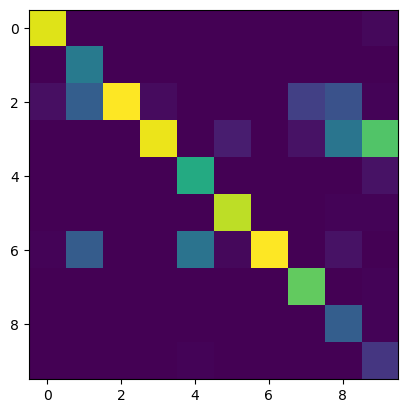

In [70]:
from sklearn.metrics import confusion_matrix

plt.imshow(confusion_matrix(test_pred.argmax(1), test_labels.argmax(1)))
# -(jnp.log(test_pred) * test_labels).mean()
# test_pred[0]
# (soln.matrix.T @ probs_1).sum()

[Text(0.5, 1.0, 'probs_2')]

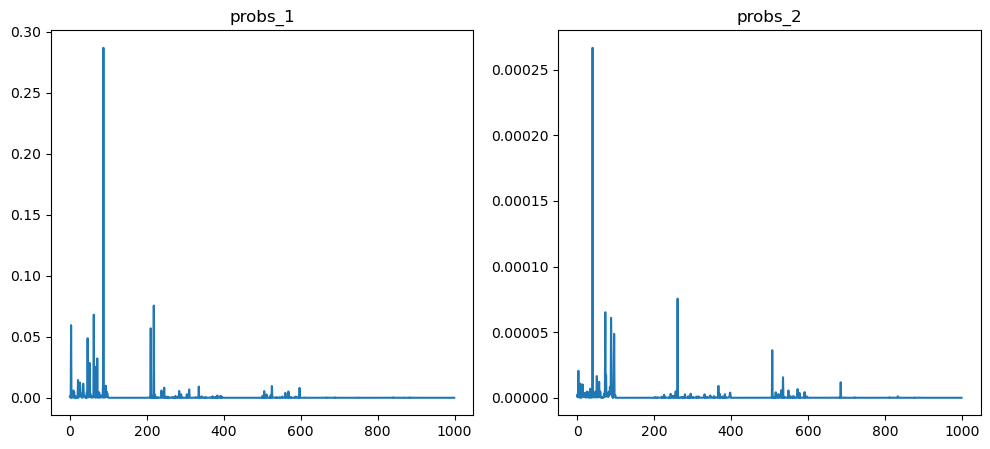

In [30]:
i = 1
test_point_1 = test_embedding_1[i]
probs_1 = nn.softmax(train_embedding_1 @ test_point_1 / 10_000)
probs_2 = soln.apply(probs_1)
fig, ax = plt.subplots(1, 2, figsize =(12, 5))

ax[0].plot(probs_1[train_sorter])
ax[1].plot(probs_2[train_sorter])

ax[0].set(title="probs_1")
ax[1].set(title="probs_2")

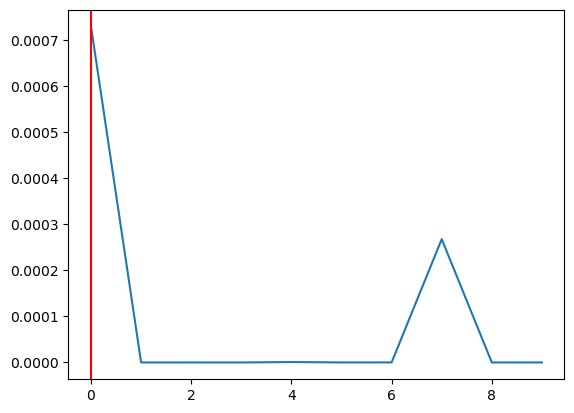

In [11]:
plt.plot((probs_2[:, None] * train_labels).sum(axis = 0))
plt.axvline(test_labels[i].argmax(), color="red")

In [69]:
train_embedding_1

Array([[  95.27821  ,   14.862137 , -229.72511  , ..., -156.10153  ,
         183.30533  ,  130.67099  ],
       [ 426.58444  ,  108.01953  , -196.94925  , ..., -118.88732  ,
          -6.358186 ,  -43.47438  ],
       [ -11.464262 , -140.82057  , -140.73854  , ..., -117.685295 ,
        -120.23526  ,  288.20505  ],
       ...,
       [-191.07387  ,  444.80215  , -305.46774  , ...,   16.59814  ,
        -110.54019  ,  295.46918  ],
       [ -65.513824 ,   74.94162  , -233.2843   , ...,   92.11877  ,
         214.75182  ,    6.8844156],
       [ 114.30113  ,  472.66293  , -382.7368   , ...,  -22.110176 ,
         289.0825   , -163.27022  ]], dtype=float32)

In [70]:
train_embedding_2

Array([[ -93.84501 ,  275.03226 ,  -99.384926, ...,  -30.919271,
        -103.94183 ,   75.465675],
       [ -65.48136 ,  -26.178482, -126.87174 , ...,   11.441797,
          38.177925,  264.77188 ],
       [ 137.06992 ,  -97.43434 ,  223.03632 , ..., -101.67682 ,
         126.66746 , -174.34132 ],
       ...,
       [-243.12444 ,   52.436737,  143.61728 , ...,  -91.774   ,
        -207.85635 ,  -43.62174 ],
       [  87.82263 ,  -10.126873,  189.47772 , ...,  165.77003 ,
         -11.846518,   22.00483 ],
       [ 295.4673  ,  373.65314 ,  -70.95954 , ...,  139.28598 ,
        -257.02713 ,  423.30612 ]], dtype=float32)